In [1]:
import sys
sys.path.append('/home/jovyan/workspace')

In [2]:
# %%sh
# rm -rf '../data/test'

In [3]:
import planetengine
from planetengine import functions as pfn
import numpy as np
from timeit import timeit

In [34]:
system = planetengine.systems.isovisc.build(res = 16)
planetengine.initials.apply(
    {'temperatureField': planetengine.initials.sinusoidal.IC(freq = 1.)},
    system,
    )
system.solve()

In [35]:
variable1 = pfn.Variable(system.velocityField, 'velocity')
variable2 = pfn.Variable(system.temperatureField, 'temperature')
constant = pfn.Constant(2.)
parameter = pfn.Parameter(lambda: variable1._get_ranges(True)[0])
shape = pfn.Shape(np.array([[0.2, 0.1], [0.9, 0.3], [0.8, 0.7], [0.4, 0.9]]))

Fitted 1 variables to the figure.
HandleNaN{Quantiles_ntiles=2{Normalise{Component_component=mag{Gradient{Projection{Component_component=rad{Region{Operation_uwop=pow{Variable_varName=velocity{};Constant_val=arr{[ 2.]}{}};Shape_varName=anon{}}}}}};Variable_varName=temperature{}}};Constant_val=arr{[ 0.]}{}}



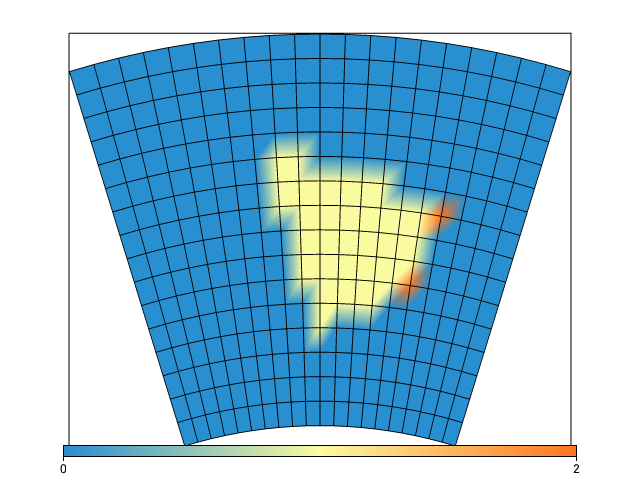

In [71]:
visVar = variable1 ** constant
visVar = variable1 ** constant
visVar = pfn.Region(visVar, shape)
visVar = pfn.Component.rad(visVar)
visVar = pfn.Gradient.mag(visVar)
visVar = pfn.Normalise(visVar, variable2)
visVar = pfn.Quantiles.median(visVar)
visVar = pfn.HandleNaN.zero(visVar)
planetengine.quickShow(system.mesh, visVar)

In [72]:
def makevar():
    var = variable1 ** constant
    var = pfn.Region(var, shape)
    var = pfn.Component.rad(var)
    var = pfn.Gradient.mag(var)
    var = pfn.Normalise(var, variable2)
    var = pfn.Quantiles.median(var)
    var = pfn.HandleNaN.zero(var)
    var = pfn.Integral(var)
    return var

In [73]:
print(round(timeit(makevar, number = 1), 3))

1.005


In [74]:
var = makevar()

In [75]:
for i in range(10):
    system.iterate()

In [76]:
def testfn(var, timings = []):
    system.iterate()
    def inner_timefn():
        var.update()
    timing = timeit(inner_timefn, number = 1)
    timings.append(timing)
    print(var, round(timing, 6))
    for inVar in var.inVars:
        timings = testfn(inVar, timings)
    return timings

In [77]:
timings = testfn(var)

<planetengine.functions.Integral object at 0x7fdadc1b3b38> 0.121768
<planetengine.functions.HandleNaN object at 0x7fdadc1ca390> 0.126123
<planetengine.functions.Quantiles object at 0x7fdadc19bfd0> 0.128768
<planetengine.functions.Normalise object at 0x7fdadc19b710> 0.123446
<planetengine.functions.Component object at 0x7fdadc19b438> 0.126404
<planetengine.functions.Gradient object at 0x7fdadda2b9e8> 0.123316
<planetengine.functions.Projection object at 0x7fdadda2bd68> 0.137415
<planetengine.functions.Component object at 0x7fdadda2b048> 0.010652
<planetengine.functions.Region object at 0x7fdadda37898> 0.008895
<planetengine.functions.Operations object at 0x7fdadda379e8> 0.008305
<planetengine.functions.Variable object at 0x7fdaec15c9e8> 0.008723
<planetengine.functions.Constant object at 0x7fdaec15c390> 2.2e-05
<planetengine.functions.Shape object at 0x7fdaec15c080> 2.5e-05
<planetengine.functions.Variable object at 0x7fdaec15c278> 0.004982
<planetengine.functions.Constant object at 0x7

In [78]:
timings

[0.12176809799984767,
 0.12612311199973192,
 0.12876801900074497,
 0.12344587499956106,
 0.1264036370002941,
 0.12331598600030702,
 0.13741533200027334,
 0.010652279999703751,
 0.008894706999853952,
 0.008304821999445267,
 0.008723210999960429,
 2.1830000150657725e-05,
 2.542099991842406e-05,
 0.004982163999557088,
 2.082899936795002e-05]

In [79]:
var.var.evaluate()

array([[ 0.13571682]])

In [80]:
system.iterate()
print(var.evaluate())
print(var.evaluate())
for i in range(10):
    system.iterate()
print(var.evaluate())
print(var.evaluate())

[[ 0.13571682]]
[[ 0.13571682]]
[[ 0.13571682]]
[[ 0.13571682]]


In [81]:
def testfn():
    freshsteps = []
    stalesteps = []
    system.iterate()
    for i in range(3):
        system.iterate()
        freshsteps.append(timeit(var.evaluate, number = 1))
        for i in range(3):
            stalesteps.append(timeit(var.evaluate, number = 1))
    average_fresh = round(sum(freshsteps) / len(freshsteps), 5)
    average_stale = round(sum(stalesteps) / len(stalesteps), 5)
    ratio = round(average_fresh / average_stale, 5)
    return(average_fresh, average_stale, ratio)
print(testfn())

(0.11801, 0.0121, 9.75289)


In [89]:
system.iterate()
timeit(var.update, number = 1)

0.11387223299971083

In [90]:
system.iterate()
timeit(var.evaluate, number = 1)

0.11408206299984158

In [84]:
system.iterate()
timeit(var.var.update, number = 1)

0.0018843630004994338

In [85]:
system.iterate()
timeit(var.var.evaluate, number = 1)

6.401800055755302e-05

In [92]:
system.iterate()
timeit(var.inVar.update, number = 1)

0.11528726399956213

In [157]:
testvar = var.inVar.inVars[0].inVar.inVars[0].inVar.inVar
testvar

In [158]:
system.iterate()
timeit(testvar.update, number = 1)

0.10877023200009717

In [159]:
testvar = var.inVar.inVars[0].inVar.inVars[0].inVar.inVar.inVar
testvar

In [160]:
system.iterate()
timeit(testvar.update, number = 1)

0.010026920999735012

In [ ]:
### BINGO ###
# It's the projector that's slow